### **Visualization of Hand Pose Estimation**

This notebook is used to visualize hand pose estimation results for specified datasets & case from *Meta's processed data*. You may find available datasets and visualization options below


In [1]:
import json
import os
import pickle
import shutil
import sys
import matplotlib.pyplot as plt
import cv2
import glob
import numpy as np
from PIL import Image
import pandas as pd

from ego4d.internal.human_pose.dataset import (
    get_synced_timesync_df,
    SyncedEgoExoCaptureDset,
)
from ego4d.internal.human_pose.camera import (
    batch_xworld_to_yimage,
    create_camera,
    create_camera_data,
    get_aria_camera_models,
)
from ego4d.internal.human_pose.pose_estimator import PoseModel
%matplotlib inline

apex is not installed
apex is not installed
apex is not installed


**Choose dataset**

In [3]:
# All datasets
dataset_root = "/media/jinxu/New Volume/ego4dData" # '/mnt/shared/ego4dData'
dataset_dir = os.path.join(dataset_root, 'cache')
print('All datasets:\n', os.listdir(dataset_dir))

All datasets:
 ['iu_music']


In [4]:
################## MODIFY ###################
test_case = 'iu_music'
#############################################

#### wholebody Pose2d Visualization

In [10]:
# Load dataset
dset = SyncedEgoExoCaptureDset(
    data_dir=dataset_root,
    dataset_json_path=f'{dataset_root}/cache/{test_case}/dataset/data.json',
    read_frames=False,
)

# Load human body bbox 
bbox_file = f"{dataset_root}/cache/{test_case}/dataset/body/bbox/bbox.pkl"
assert os.path.exists(bbox_file), f"{bbox_file} doesn'\t exist"
with open(bbox_file, "rb") as f:
    body_bboxes = pickle.load(f)

# Load human body keypoints result from mode_pose2d
pose2d_dir = f'{dataset_root}/cache/{test_case}/dataset/body/pose2d'
pose2d_file = os.path.join(pose2d_dir, "pose2d.pkl")
assert os.path.exists(pose2d_file), f"{pose2d_file} does not exist"
with open(pose2d_file, "rb") as f:
    body_poses2d = pickle.load(f)

# Pose visualization model
pose_config = "external/mmlab/mmpose/configs/wholebody/2d_kpt_sview_rgb_img/topdown_heatmap/coco-wholebody/hrnet_w48_coco_wholebody_384x288_dark_plus.py"
pose_checkpoint = "https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_coco_wholebody_384x288_dark-f5726563_20200918.pth"
body_pose_model = PoseModel(
    pose_config, 
    pose_checkpoint, 
    rgb_keypoint_thres=0.7, 
    rgb_keypoint_vis_thres=0.7)

load checkpoint from http path: https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_coco_wholebody_384x288_dark-f5726563_20200918.pth


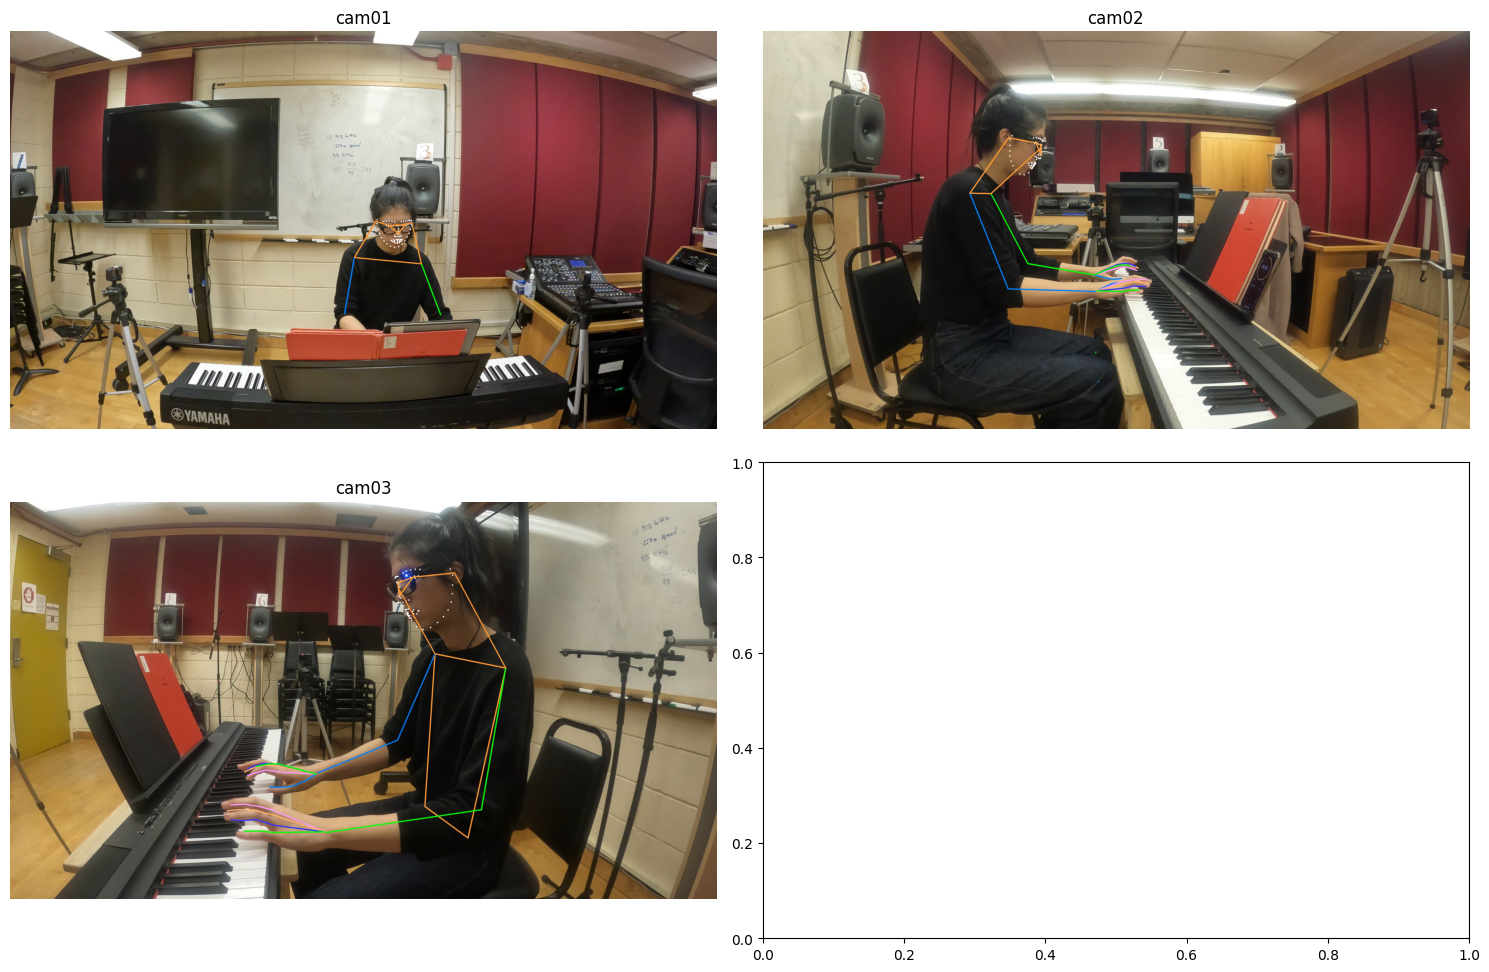

In [14]:
############# MODIFY #############
rand_cam = ['cam01','cam02','cam03'] # 'cam02'
rand_idx = 1
##################################

# Visualization
if isinstance(rand_cam, list):
    num_row = (len(rand_cam) - 1)//2 + 1
    fig,axes = plt.subplots(num_row, 2, figsize=(15, 5*num_row))
    # Iterate each camera
    for idx, curr_cam in enumerate(rand_cam):
        rand_img_path = dset[rand_idx][curr_cam]['abs_frame_path']
        rand_img = cv2.imread(rand_img_path)

        curr_pose2d = body_poses2d[rand_idx][curr_cam]
        curr_bbox = np.zeros(5) # np.append(bboxes[rand_idx][rand_cam], 1)
        pose_results = [{'bbox': curr_bbox,
                        "keypoints":curr_pose2d}]
        # Visualization
        save_path = f'temp_vis_dir/body_pose2d_{curr_cam}.jpg'
        body_pose_model.draw_poses2d(pose_results, rand_img, save_path)

        vis_img = cv2.imread(save_path)
        row_idx = idx // 2
        col_idx = idx % 2
        axes[row_idx, col_idx].imshow(vis_img[:,:,::-1])
        axes[row_idx, col_idx].set_title(curr_cam)
        axes[row_idx, col_idx].set_axis_off()
    fig.tight_layout()
else: # Visualization for single view camera
    rand_img_path = dset[rand_idx][rand_cam]['abs_frame_path']
    rand_img = cv2.imread(rand_img_path)

    curr_pose2d = body_poses2d[rand_idx][rand_cam]
    curr_bbox = np.zeros(5) # np.append(bboxes[rand_idx][rand_cam], 1)
    pose_results = [{'bbox': curr_bbox,
                    "keypoints":curr_pose2d}]
    # Visualization
    save_path = 'transfer_test/body_pose2d_vis.jpg'
    body_pose_model.draw_poses2d(pose_results, rand_img, save_path)

    vis_img = cv2.imread(save_path)
    plt.figure(figsize=(12,6))
    plt.imshow(vis_img[:,:,::-1])

#### Exo hand pose2d visualization

In [4]:
####################################
kpts_vis_threshold = 0.3
####################################

# Load dataset
dset = SyncedEgoExoCaptureDset(
    data_dir=dataset_root,
    dataset_json_path=f'{dataset_root}/cache/{test_case}/dataset/data.json',
    read_frames=False,
)

# Load exo hand pose2d and bbox results from .pkl file
exo_hand_pose2d_dir = f"{dataset_root}/cache/{test_case}/dataset/hand/pose2d/exo_pose2d.pkl"
with open(exo_hand_pose2d_dir, "rb") as f:
    exo_hand_poses2d = pickle.load(f)
exo_hand_bbox_dir = f"{dataset_root}/cache/{test_case}/dataset/hand/bbox/exo_bbox.pkl"
with open(exo_hand_bbox_dir, "rb") as f:
    exo_hand_bbox = pickle.load(f)

# Pose visualization model
hand_pose_config = 'external/mmlab/mmpose/configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/coco_wholebody_hand/hrnetv2_w18_coco_wholebody_hand_256x256_dark.py'
hand_pose_ckpt = 'https://download.openmmlab.com/mmpose/hand/dark/hrnetv2_w18_coco_wholebody_hand_256x256_dark-a9228c9c_20210908.pth'
hand_pose_model = PoseModel(hand_pose_config, 
                            hand_pose_ckpt, 
                            rgb_keypoint_thres=kpts_vis_threshold, 
                            rgb_keypoint_vis_thres=kpts_vis_threshold,
                            refine_bbox=False)

load checkpoint from http path: https://download.openmmlab.com/mmpose/hand/dark/hrnetv2_w18_coco_wholebody_hand_256x256_dark-a9228c9c_20210908.pth


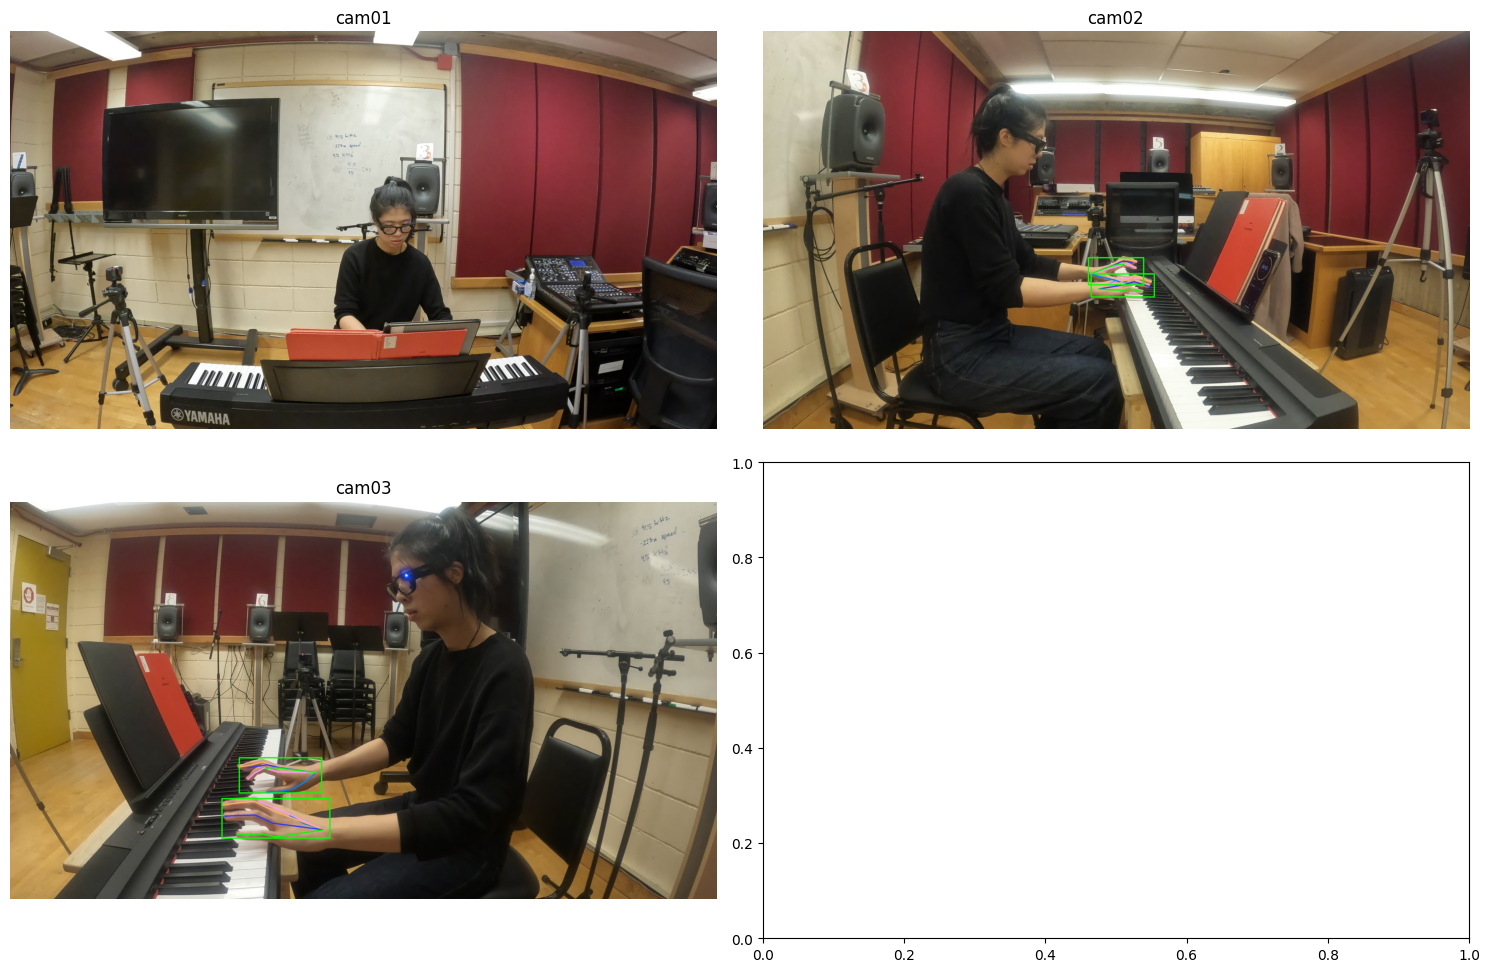

In [9]:
############# MODIFY #############
rand_cam = ['cam01','cam02','cam03']
rand_idx = 1
##################################

# Visualization
if isinstance(rand_cam, list):
    num_row = (len(rand_cam) - 1)//2 + 1
    fig,axes = plt.subplots(num_row, 2, figsize=(15, 5*num_row))
    # Iterate each camera
    for idx, curr_cam in enumerate(rand_cam):
        # Visualization for single view camera
        rand_img_path = dset[rand_idx][curr_cam]['abs_frame_path']
        rand_img = cv2.imread(rand_img_path)

        curr_pose2d = exo_hand_poses2d[rand_idx][curr_cam]
        curr_bbox = exo_hand_bbox[rand_idx][curr_cam]
        pose_results = [{'bbox': np.append(curr_bbox[i], 1),
                        "keypoints": curr_pose2d[i]} for i in range(2)]
        # Visualization
        save_path = f'temp_vis_dir/exo_hand_pose2d_{test_case}_{curr_cam}.jpg'
        vis_twoHand = cv2.imread(rand_img_path)
        hand_pose_model.draw_poses2d([pose_results[0]], vis_twoHand, save_path)
        vis_twoHand = cv2.imread(save_path)
        hand_pose_model.draw_poses2d([pose_results[1]], vis_twoHand, save_path)

        vis_img = cv2.imread(save_path)
        row_idx = idx // 2
        col_idx = idx % 2
        axes[row_idx, col_idx].imshow(vis_img[:,:,::-1])
        axes[row_idx, col_idx].set_title(curr_cam)
        axes[row_idx, col_idx].set_axis_off()
    fig.tight_layout()
else: 
    # Visualization for single view camera
    rand_img_path = dset[rand_idx][rand_cam]['abs_frame_path']
    rand_img = cv2.imread(rand_img_path)

    curr_pose2d = exo_hand_poses2d[rand_idx][rand_cam]
    curr_bbox = exo_hand_bbox[rand_idx][rand_cam]
    pose_results = [{'bbox': np.append(curr_bbox[i], 1),
                     "keypoints": curr_pose2d[i]} for i in range(2)]
    # Visualization
    save_path = f'temp_vis_dir/exo_hand_pose2d_{test_case}_{rand_cam}.jpg'
    vis_twoHand = cv2.imread(rand_img_path)
    hand_pose_model.draw_poses2d([pose_results[0]], vis_twoHand, save_path)
    vis_twoHand = cv2.imread(save_path)
    hand_pose_model.draw_poses2d([pose_results[1]], vis_twoHand, save_path)

    vis_img = cv2.imread(save_path)
    plt.figure(figsize=(12,6))
    plt.imshow(vis_img[:,:,::-1])

#### Ego hand pose2d visualization

In [23]:
#####################################
kpts_vis_threshold = 0.1
#####################################

# Load dataset
dset = SyncedEgoExoCaptureDset(
    data_dir=dataset_root,
    dataset_json_path=f'{dataset_root}/cache/{test_case}/dataset/data.json',
    read_frames=False,
)
# Ego camera name
ego_cam_name = 'aria_rgb'

# Load exo hand pose2d and bbox results from .pkl file
ego_hand_pose2d_dir = f"{dataset_root}/cache/{test_case}/dataset/hand/pose2d/ego_pose2d.pkl"
with open(ego_hand_pose2d_dir, "rb") as f:
    ego_hand_poses2d = pickle.load(f)
ego_hand_bbox_dir = f"{dataset_root}/cache/{test_case}/dataset/hand/bbox/ego_bbox.pkl"
with open(ego_hand_bbox_dir, "rb") as f:
    ego_hand_bbox = pickle.load(f)

# Pose visualization model
hand_pose_config = 'external/mmlab/mmpose/configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/coco_wholebody_hand/hrnetv2_w18_coco_wholebody_hand_256x256_dark.py'
hand_pose_ckpt = 'https://download.openmmlab.com/mmpose/hand/dark/hrnetv2_w18_coco_wholebody_hand_256x256_dark-a9228c9c_20210908.pth'
hand_pose_model = PoseModel(hand_pose_config, 
                            hand_pose_ckpt, 
                            rgb_keypoint_thres=kpts_vis_threshold, 
                            rgb_keypoint_vis_thres=kpts_vis_threshold,
                            refine_bbox=False)

load checkpoint from http path: https://download.openmmlab.com/mmpose/hand/dark/hrnetv2_w18_coco_wholebody_hand_256x256_dark-a9228c9c_20210908.pth


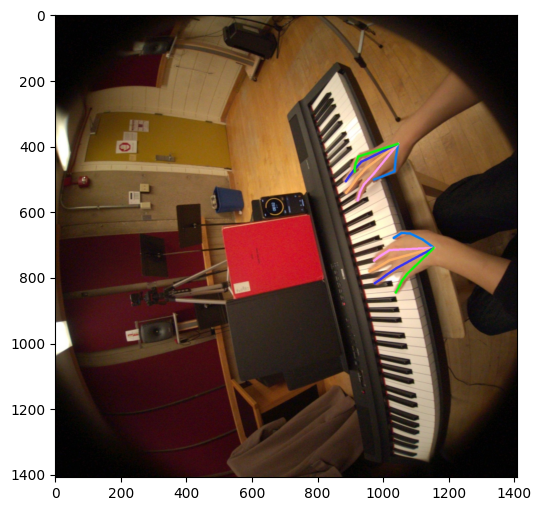

In [25]:
############# MODIFY #############
rand_idx = 100
##################################

# Visualization for single view camera
rand_img_path = dset[rand_idx][ego_cam_name]['abs_frame_path']
rand_img = cv2.imread(rand_img_path)

curr_pose2d = ego_hand_poses2d[rand_idx]
# curr_bbox = ego_hand_bbox[rand_idx]
pose_results = [{'bbox': np.zeros(5),
                 "keypoints": curr_pose2d[i]} for i in range(2)]
# Visualization
save_path = f'temp_vis_dir/ego_hand_pose2d_{test_case}_{ego_cam_name}.jpg'
vis_twoHand = cv2.imread(rand_img_path)
hand_pose_model.draw_poses2d([pose_results[0]], vis_twoHand, save_path)
vis_twoHand = cv2.imread(save_path)
hand_pose_model.draw_poses2d([pose_results[1]], vis_twoHand, save_path)

vis_img = cv2.imread(save_path)
plt.figure(figsize=(12,6))
plt.imshow(vis_img[:,:,::-1])

#### Exo hand pose3d visualization

In [28]:
#############################################
tri_threshold = 0.3 # This value determines which pose3d triangulation pose result to display
exo_cam_names = ['cam01','cam02','cam03']
kpts_vis_threshold = 0.3
#############################################

# Load dataset
dset = SyncedEgoExoCaptureDset(
    data_dir=dataset_root,
    dataset_json_path=f'{dataset_root}/cache/{test_case}/dataset/data.json',
    read_frames=False,
)

# Load exo hand pose2d and bbox results from .pkl file
exo_hand_pose3d_dir = f"{dataset_root}/cache/{test_case}/dataset/hand/pose3d/exo_pose3d_triThresh={tri_threshold}.pkl"
with open(exo_hand_pose3d_dir, "rb") as f:
    exo_hand_poses3d = pickle.load(f)

# Pose visualization model
hand_pose_config = 'external/mmlab/mmpose/configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/coco_wholebody_hand/hrnetv2_w18_coco_wholebody_hand_256x256_dark.py'
hand_pose_ckpt = 'https://download.openmmlab.com/mmpose/hand/dark/hrnetv2_w18_coco_wholebody_hand_256x256_dark-a9228c9c_20210908.pth'
hand_pose_model = PoseModel(hand_pose_config, 
                            hand_pose_ckpt, 
                            rgb_keypoint_thres=kpts_vis_threshold, 
                            rgb_keypoint_vis_thres=kpts_vis_threshold,
                            refine_bbox=False)

# Create both aria and exo camera
exo_cameras = {
    exo_camera_name: create_camera(dset[0][exo_camera_name]["camera_data"], None)
    for exo_camera_name in exo_cam_names
}

load checkpoint from http path: https://download.openmmlab.com/mmpose/hand/dark/hrnetv2_w18_coco_wholebody_hand_256x256_dark-a9228c9c_20210908.pth


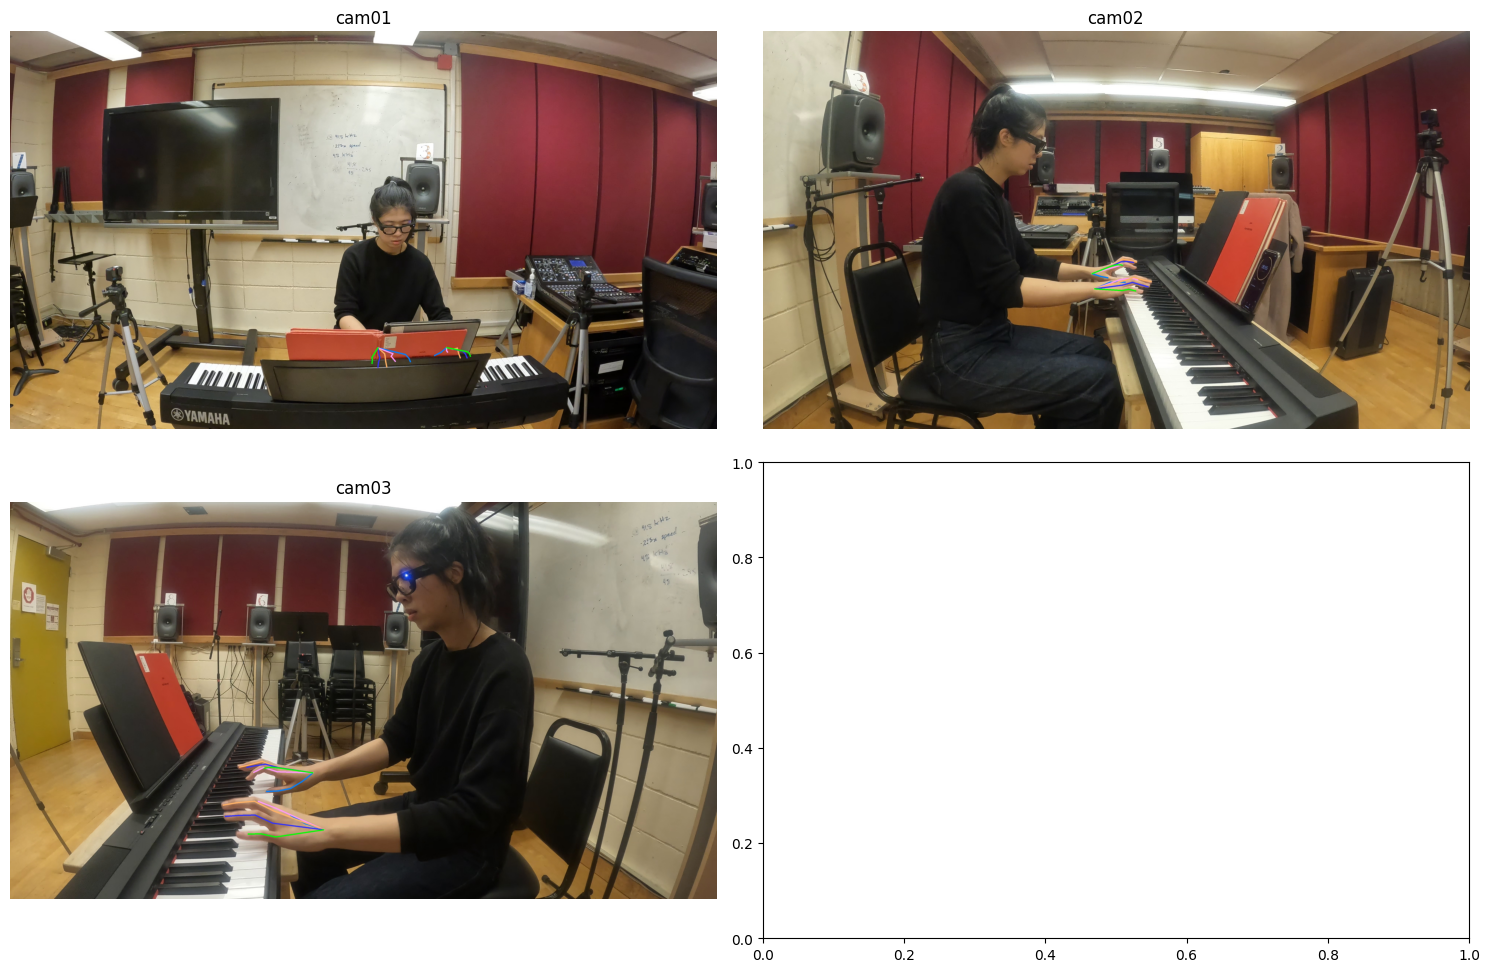

In [33]:
############# MODIFY #############
rand_cam = ['cam01','cam02','cam03'] # 'cam02'
rand_idx = 1
##################################

# Visualization
if isinstance(rand_cam, list):
    num_row = (len(rand_cam) - 1)//2 + 1
    fig,axes = plt.subplots(num_row, 2, figsize=(15, 5*num_row))
    # Iterate each camera
    for idx, curr_cam in enumerate(rand_cam):
        # Visualization for single view camera
        rand_img_path = dset[rand_idx][curr_cam]['abs_frame_path']
        rand_img = cv2.imread(rand_img_path)
        # Load pose3d for current camera
        curr_exo_hand_pose3d = exo_hand_poses3d[rand_idx]
        curr_camera = exo_cameras[curr_cam]
        projected_pose3d = batch_xworld_to_yimage(curr_exo_hand_pose3d[:, :3], curr_camera)
        projected_pose3d = np.concatenate(
            [projected_pose3d, curr_exo_hand_pose3d[:, 3].reshape(-1, 1)], axis=1
        )  ## N x 3 (17 for body; 42 for hand)

        save_path = f'temp_vis_dir/exo_hand_pose3d_{test_case}_{rand_cam}.jpg'
        hand_pose_model.draw_projected_poses3d([projected_pose3d[:21], projected_pose3d[21:]], rand_img, save_path)
        vis_img = cv2.imread(save_path)
        row_idx = idx // 2
        col_idx = idx % 2
        axes[row_idx, col_idx].imshow(vis_img[:,:,::-1])
        axes[row_idx, col_idx].set_title(curr_cam)
        axes[row_idx, col_idx].set_axis_off()
    fig.tight_layout()
else: 
    # Visualization for single view camera
    rand_img_path = dset[rand_idx][rand_cam]['abs_frame_path']
    rand_img = cv2.imread(rand_img_path)
    # Load pose3d for current camera
    curr_exo_hand_pose3d = exo_hand_poses3d[rand_idx]
    curr_camera = exo_cameras[rand_cam]
    projected_pose3d = batch_xworld_to_yimage(curr_exo_hand_pose3d[:, :3], curr_camera)
    projected_pose3d = np.concatenate(
        [projected_pose3d, curr_exo_hand_pose3d[:, 3].reshape(-1, 1)], axis=1
    )  ## N x 3 (17 for body; 42 for hand)
    # Visualization
    save_path = f'temp_vis_dir/exo_hand_pose3d_{test_case}_{rand_cam}.jpg'
    hand_pose_model.draw_projected_poses3d([projected_pose3d[:21], projected_pose3d[21:]], rand_img, save_path)
    vis_img = cv2.imread(save_path)
    plt.figure(figsize=(12,6))
    plt.imshow(vis_img[:,:,::-1])

#### EgoExo hand pose3d visualization

In [5]:
#############################################
tri_threshold = 0.3 # This value determines which pose3d triangulation pose result to display
kpts_vis_threshold = 0.3
exo_cam_names = ['cam01','cam02','cam03']
ego_cam_name = 'aria_rgb'
#############################################

# Load dataset
dset = SyncedEgoExoCaptureDset(
    data_dir=dataset_root,
    dataset_json_path=f'{dataset_root}/cache/{test_case}/dataset/data.json',
    read_frames=False,
)

# Load exo hand pose2d and bbox results from .pkl file
egoexo_hand_pose3d_dir = f"{dataset_root}/cache/{test_case}/dataset/hand/pose3d/egoexo_pose3d_triThresh={tri_threshold}.pkl"
with open(egoexo_hand_pose3d_dir, "rb") as f:
    egoexo_hand_poses3d = pickle.load(f)

# Pose visualization model
hand_pose_config = 'external/mmlab/mmpose/configs/hand/2d_kpt_sview_rgb_img/topdown_heatmap/coco_wholebody_hand/hrnetv2_w18_coco_wholebody_hand_256x256_dark.py'
hand_pose_ckpt = 'https://download.openmmlab.com/mmpose/hand/dark/hrnetv2_w18_coco_wholebody_hand_256x256_dark-a9228c9c_20210908.pth'
hand_pose_model = PoseModel(hand_pose_config, 
                            hand_pose_ckpt, 
                            rgb_keypoint_thres=kpts_vis_threshold, 
                            rgb_keypoint_vis_thres=kpts_vis_threshold,
                            refine_bbox=False)

# Create both aria and exo camera
aria_exo_cameras = {
    exo_camera_name: create_camera(dset[0][exo_camera_name]["camera_data"], None)
    for exo_camera_name in exo_cam_names
}

load checkpoint from http path: https://download.openmmlab.com/mmpose/hand/dark/hrnetv2_w18_coco_wholebody_hand_256x256_dark-a9228c9c_20210908.pth


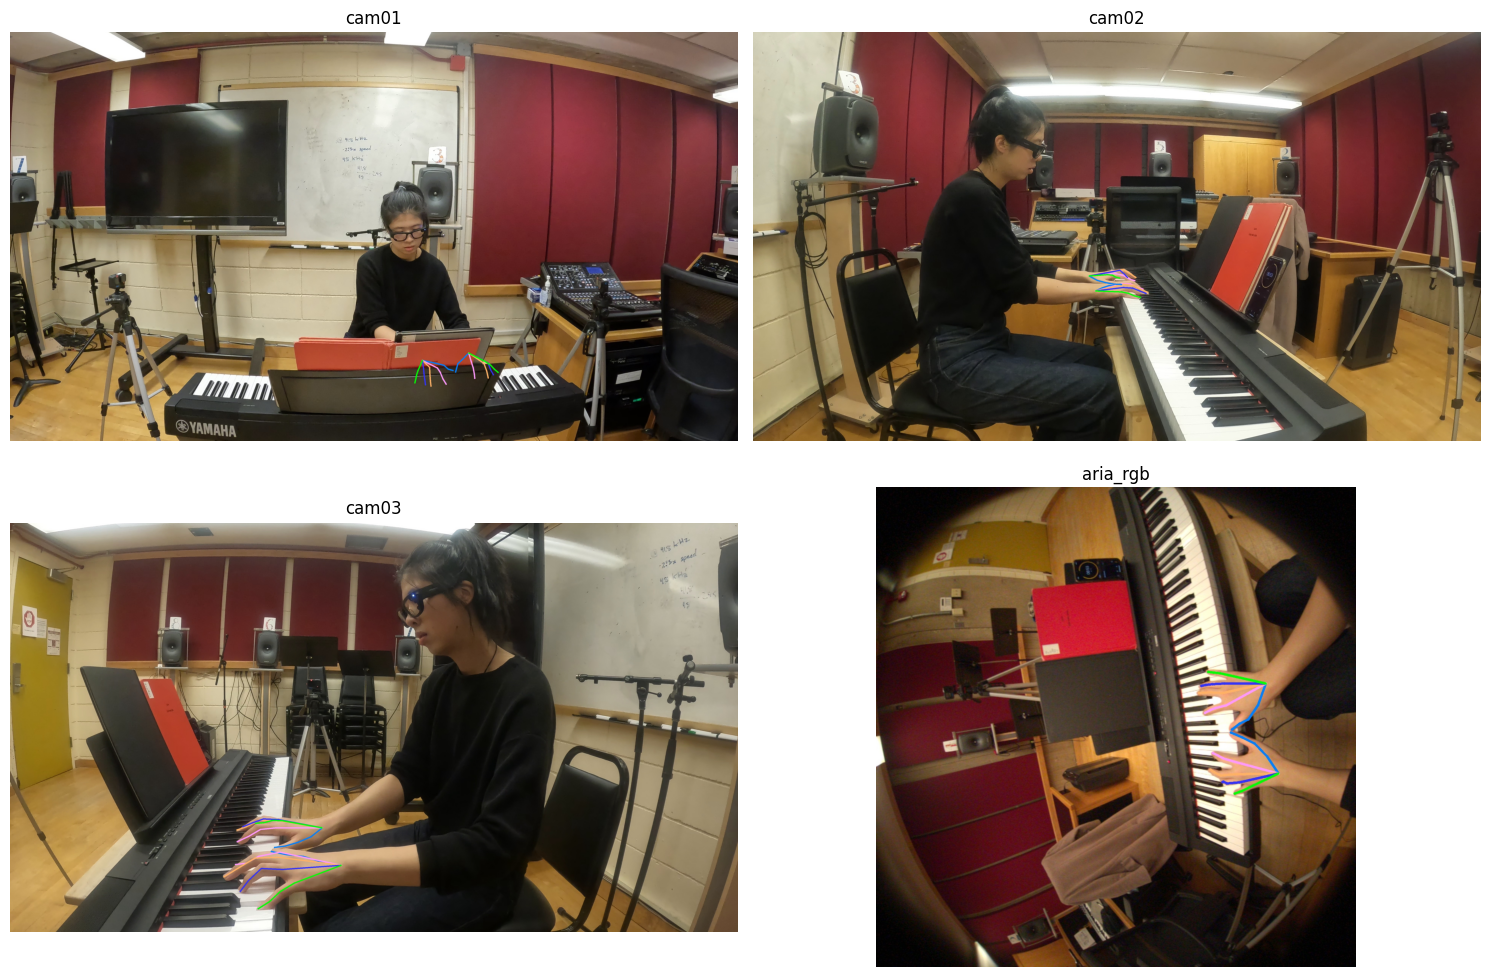

In [9]:
############# MODIFY #############
rand_cam =  ['cam01','cam02','cam03', 'aria_rgb'] # 'aria_rgb'
rand_idx = 50
##################################

# Visualization
if isinstance(rand_cam, list):
    # Add aria camera
    aria_exo_cameras['aria_rgb'] = create_camera(dset[rand_idx]['aria_rgb']["camera_data"], None)
    num_row = (len(rand_cam) - 1)//2 + 1
    fig,axes = plt.subplots(num_row, 2, figsize=(15, 5*num_row))
    # Iterate each camera
    for idx, curr_cam in enumerate(rand_cam):
        # Visualization for single view camera
        rand_img_path = dset[rand_idx][curr_cam]['abs_frame_path']
        rand_img = cv2.imread(rand_img_path)
        # Load pose3d for current camera
        curr_egoexo_hand_pose3d = egoexo_hand_poses3d[rand_idx]
        curr_camera = aria_exo_cameras[curr_cam]
        projected_pose3d = batch_xworld_to_yimage(curr_egoexo_hand_pose3d[:, :3], curr_camera)
        projected_pose3d = np.concatenate(
            [projected_pose3d, curr_egoexo_hand_pose3d[:, 3].reshape(-1, 1)], axis=1
        )  ## N x 3 (17 for body; 42 for hand)

        save_path = f'temp_vis_dir/exo_hand_pose3d_{test_case}_{rand_cam}.jpg'
        hand_pose_model.draw_projected_poses3d([projected_pose3d[:21], projected_pose3d[21:]], rand_img, save_path)
        vis_img = cv2.imread(save_path)
        row_idx = idx // 2
        col_idx = idx % 2
        axes[row_idx, col_idx].imshow(vis_img[:,:,::-1])
        axes[row_idx, col_idx].set_title(curr_cam)
        axes[row_idx, col_idx].set_axis_off()
    fig.tight_layout()
else: 
    # Add aria camera
    aria_exo_cameras['aria_rgb'] = create_camera(dset[rand_idx]['aria_rgb']["camera_data"], None)
    # Visualization for single view camera
    rand_img_path = dset[rand_idx][rand_cam]['abs_frame_path']
    rand_img = cv2.imread(rand_img_path)
    # Load pose3d for current camera
    curr_egoexo_hand_pose3d = egoexo_hand_poses3d[rand_idx]
    curr_camera = aria_exo_cameras[rand_cam]
    projected_pose3d = batch_xworld_to_yimage(curr_egoexo_hand_pose3d[:, :3], curr_camera)
    projected_pose3d = np.concatenate(
        [projected_pose3d, curr_egoexo_hand_pose3d[:, 3].reshape(-1, 1)], axis=1
    )  ## N x 3 (17 for body; 42 for hand)
    # Visualization
    save_path = f'temp_vis_dir/egoexo_hand_pose3d_{test_case}_{rand_cam}.jpg'
    hand_pose_model.draw_projected_poses3d([projected_pose3d[:21], projected_pose3d[21:]], rand_img, save_path)
    vis_img = cv2.imread(save_path)
    plt.figure(figsize=(12,6))
    plt.imshow(vis_img[:,:,::-1])
    plt.title(rand_cam)